# <center>1.10 - Feature Selection</center>

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## <center>Feature importance</center>

In [2]:
# Загружаем датасет и присоединим к нему датсет с таргетом
rides_info = pd.read_csv('../data/rides_info.csv')
car_info = pd.read_csv('../data/car_info.csv')
#rider_info = pd.read_csv('../data/rider_info.csv')
rides_info = rides_info.merge(car_info, on = 'car_id', how = 'left')
#rides_info = rides_info.merge(rider_info, on = 'user_id', how = 'left')
rides_info.head()

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,...,deviation_normal,car_type,fuel_type,car_rating,year_to_start,riders,model,target_2,year_to_work,target_1
0,Y14530989r,A-1021565b,p1q,2020-01-01,6.93,80,1193,43,70.000000,1,...,1.296,premium,petrol,24.6,2014,7458,Audi A3,engine_fuel,2020,1.195372e+06
1,D18145222v,A-1021565b,m1I,2020-01-01,4.05,124,6194,52,107.000000,1,...,0.949,premium,petrol,24.6,2014,7458,Audi A3,engine_fuel,2020,1.195372e+06
2,v13985183J,A-1021565b,X1V,2020-01-02,1.40,43,641,85,166.947342,1,...,2.967,premium,petrol,24.6,2014,7458,Audi A3,engine_fuel,2020,1.195372e+06
3,H30217054J,A-1021565b,r1Y,2020-01-02,4.82,100,1495,73,155.803560,0,...,4.782,premium,petrol,24.6,2014,7458,Audi A3,engine_fuel,2020,1.195372e+06
4,c15454802r,A-1021565b,r1O,2020-01-03,2.19,38,488,33,92.000000,0,...,3.615,premium,petrol,24.6,2014,7458,Audi A3,engine_fuel,2020,1.195372e+06


In [3]:
drop_cols = ['user_id', 'car_id', 'ride_id', 'ride_date', 'target_1', 'target_2']
cat_cols = ['car_type', 'fuel_type', 'model']

Для примера возьмем библиотеку градиентного бустинга CatBoost

In [4]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
import shap

In [5]:
X = rides_info.drop(drop_cols, axis=1)
y = rides_info['target_1']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model = CatBoostRegressor(cat_features=cat_cols,
                          thread_count=-1)
                         #eval_metric='RMSE')
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=150, plot=False, 
          early_stopping_rounds=100)

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.138709
0:	learn: 2776423.2144597	test: 2757352.5036619	best: 2757352.5036619 (0)	total: 106ms	remaining: 1m 45s
150:	learn: 2232308.2762153	test: 2227335.6624164	best: 2227335.6624164 (150)	total: 7.18s	remaining: 40.4s
300:	learn: 1960921.7428205	test: 1959401.8262822	best: 1959401.8262822 (300)	total: 14.4s	remaining: 33.4s
450:	learn: 1763450.4619573	test: 1763089.7695007	best: 1763089.7695007 (450)	total: 21.6s	remaining: 26.3s
600:	learn: 1610792.7018985	test: 1611610.5561119	best: 1611610.5561119 (600)	total: 28.8s	remaining: 19.1s
750:	learn: 1481021.5994085	test: 1481419.8559624	best: 1481419.8559624 (750)	total: 36.2s	remaining: 12s
900:	learn: 1364872.1655500	test: 1364602.4619783	best: 1364602.4619783 (900)	total: 43.3s	remaining: 4.76s
999:	learn: 1304291.3069625	test: 1303658.7598339	best: 1303658.7598339 (999)	total: 48.2s	remaining: 0us

bestTest = 1303658.76
bestIteration = 999



In [8]:
# посмотрим на важность признаков катбуста
fi = model.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,riders,33.380082
1,car_rating,29.289932
2,year_to_work,12.069604
3,model,8.798910
4,car_type,4.621655
5,year_to_start,4.313349
6,deviation_normal,4.277116
7,user_ride_quality,1.385588
8,fuel_type,0.740134
9,stop_times,0.689408


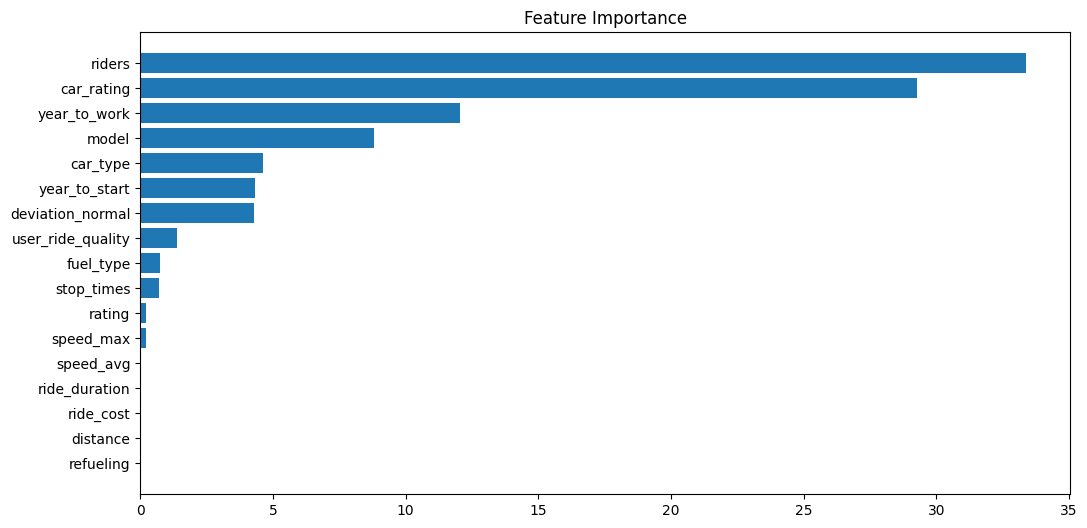

In [17]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

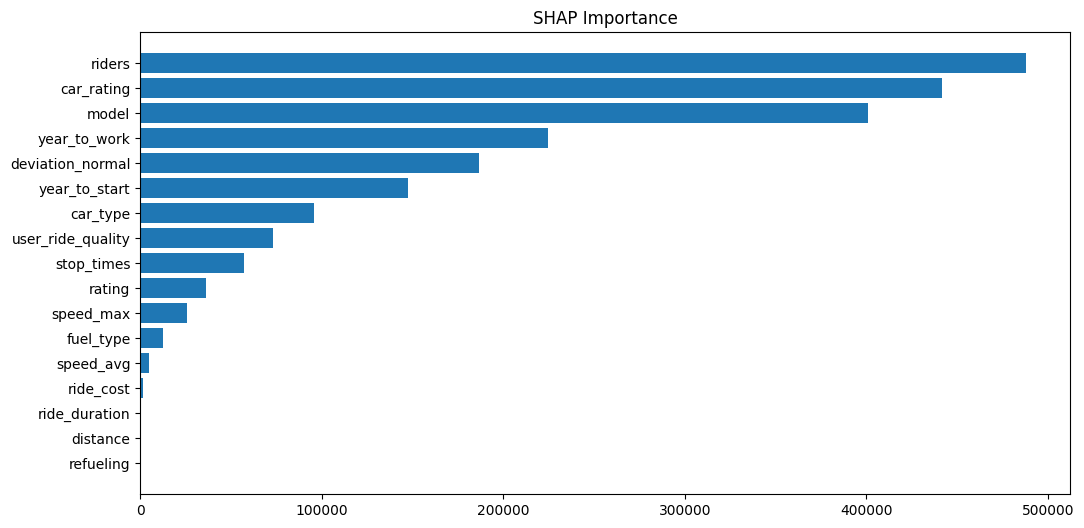

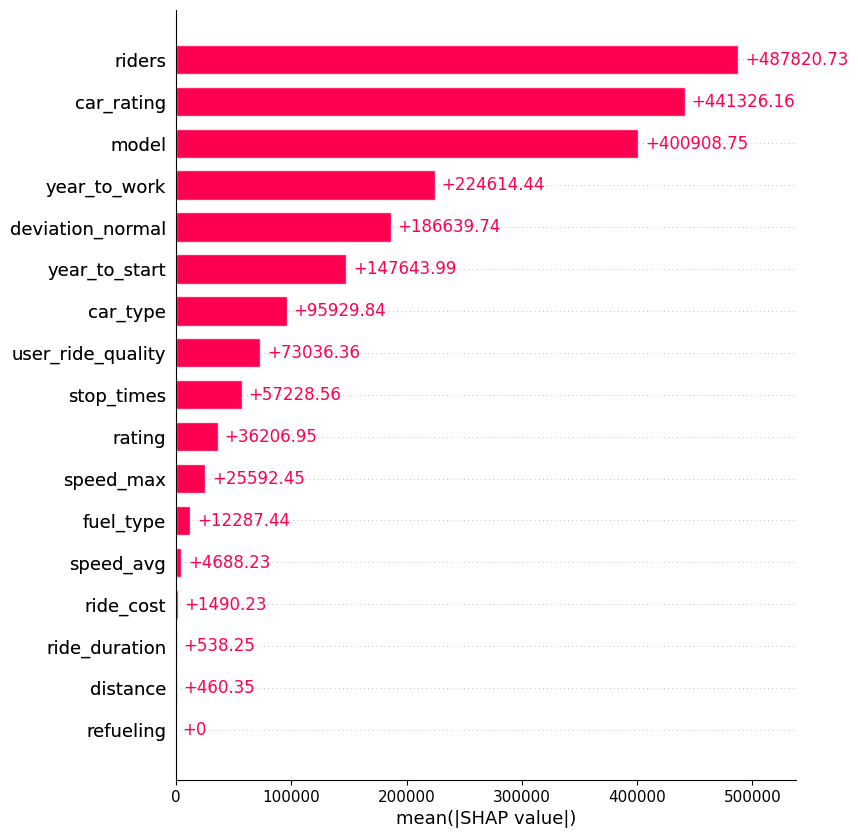

In [19]:
# Посмотрим на SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('SHAP Importance');
fig = plt.figure(figsize=(12, 6))
shap.plots.bar(shap_values, max_display=X_test.shape[0])

## <center> Permutation importance</center>

Text(0.5, 1.0, 'Permutation Importance')

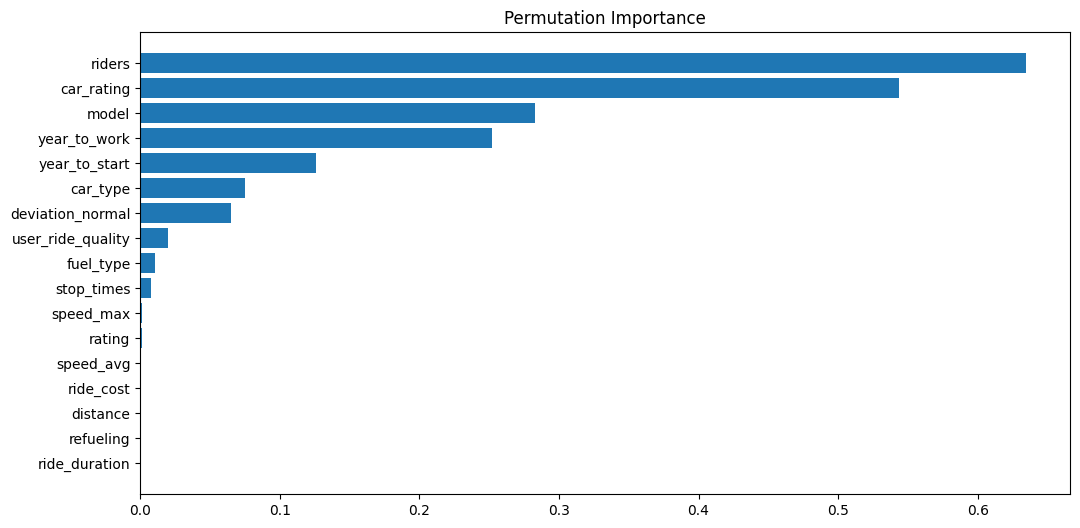

In [20]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance')

## <center>CatBoost feature selection</center>

In [21]:
summary = model.select_features(X_train, y_train, 
                      eval_set=(X_test, y_test),
                      features_for_select='0-16',
                      num_features_to_select=10,
                      steps=5,
                      train_final_model=False,
                      logging_level='Silent')

In [24]:
print(summary['selected_features_names'])
print(f"Best loss: {summary['loss_graph']['loss_values'][-1]}")

['stop_times', 'user_ride_quality', 'deviation_normal', 'car_type', 'fuel_type', 'car_rating', 'year_to_start', 'riders', 'model', 'year_to_work']
Best loss: 1310464.165509036


In [23]:
summary

{'selected_features': [5, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 'eliminated_features_names': ['ride_duration',
  'refueling',
  'distance',
  'ride_cost',
  'speed_avg',
  'speed_max',
  'rating'],
 'loss_graph': {'main_indices': [0, 2, 3, 5, 6],
  'removed_features_count': [0, 1, 2, 3, 4, 5, 6, 7],
  'loss_values': [1323316.213265063,
   1314212.3015862817,
   1314212.3015862817,
   1305599.9425906397,
   1307549.6150102518,
   1317654.6671939783,
   1308579.6064572432,
   1310464.165509036]},
 'eliminated_features': [1, 7, 6, 2, 3, 4, 0],
 'selected_features_names': ['stop_times',
  'user_ride_quality',
  'deviation_normal',
  'car_type',
  'fuel_type',
  'car_rating',
  'year_to_start',
  'riders',
  'model',
  'year_to_work']}

## <center> Random feature</center>

In [28]:
# Добавим рандомный признак в датасет
rides_info['random'] = np.random.randint(-200, 200, rides_info.shape[0])

In [29]:
X = rides_info.drop(drop_cols, axis=1)
y = rides_info['target_1']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
model = CatBoostRegressor(cat_features=cat_cols,
                          thread_count=-1)
                         #eval_metric='RMSE')
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=150, plot=False, 
          early_stopping_rounds=100)

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.138709
0:	learn: 2776468.3904300	test: 2757404.1779355	best: 2757404.1779355 (0)	total: 53.3ms	remaining: 53.2s
150:	learn: 2238563.1823805	test: 2232691.5580397	best: 2232691.5580397 (150)	total: 6.92s	remaining: 38.9s
300:	learn: 1970258.3738219	test: 1967718.7260840	best: 1967718.7260840 (300)	total: 13.9s	remaining: 32.3s
450:	learn: 1781496.8714194	test: 1779350.3091127	best: 1779350.3091127 (450)	total: 20.9s	remaining: 25.4s
600:	learn: 1617855.8590434	test: 1616329.1074672	best: 1616329.1074672 (600)	total: 27.9s	remaining: 18.6s
750:	learn: 1486720.1021801	test: 1485406.6274826	best: 1485406.6274826 (750)	total: 34.9s	remaining: 11.6s
900:	learn: 1387537.2203116	test: 1384808.2068184	best: 1384808.2068184 (900)	total: 41.9s	remaining: 4.6s
999:	learn: 1325506.3195221	test: 1323014.6384364	best: 1323014.6384364 (999)	total: 46.5s	remaining: 0us

bestTest = 1323014.638
bestIteration = 999



In [32]:
# посмотрим на важность признаков катбуста
fi = model.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,riders,33.043963
1,car_rating,29.904740
2,year_to_work,11.134365
3,model,8.546519
4,car_type,5.120750
5,year_to_start,4.711988
6,deviation_normal,4.239843
7,user_ride_quality,1.421873
8,fuel_type,0.696253
9,stop_times,0.673162


## <center> Boruta </center>

<img src="https://miro.medium.com/max/720/1*yqAUlMtPUiFyr8gYLFagTA.webp">

In [ ]:
#!pip install boruta

In [43]:
X_train_one_hot = pd.get_dummies(X_train[cat_cols])
X_train = pd.concat((X_train.drop(columns=cat_cols), X_train_one_hot), axis=1).fillna(0)
X_train.head()

,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,...,model_Renault Sandero,model_Skoda Rapid,model_Smart Coupe,model_Smart ForFour,model_Smart ForTwo,model_Tesla Model 3,model_VW Polo,model_VW Polo VI,model_VW Tiguan,model_Volkswagen ID.4
57857,6.25,35,380,80,113.517456,0,2902.780646,0,6.831907,-16.336,...,0,0,0,0,0,0,0,0,0,0
238419,3.88,26,307,43,68.000000,1,936.494659,0,2.536357,16.884,...,0,0,0,0,0,0,0,0,1,0
412031,7.80,215,1594,34,69.157149,0,1434.234646,0,4.666869,16.476,...,0,0,1,0,0,0,0,0,0,0
192817,3.98,54,426,42,52.000000,3,1543.446570,0,-1.139035,-4.903,...,0,0,0,0,0,0,0,1,0,0
510757,5.36,30,355,51,63.000000,0,1537.275481,0,3.370937,-3.078,...,0,0,0,0,0,0,0,0,1,0


In [46]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
###initialize Boruta
forest = RandomForestRegressor(
   n_jobs = -1, 
   max_depth = 3
)
boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 8, # number of trials to perform
    verbose=1
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X_train), np.array(y_train))
### print results
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
red_area = X_train.columns[~(boruta.support_ | boruta.support_weak_)].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)
print('features in the red area:', red_area)

Iteration: 1 / 8
Iteration: 2 / 8
Iteration: 3 / 8
Iteration: 4 / 8
Iteration: 5 / 8
Iteration: 6 / 8
Iteration: 7 / 8


BorutaPy finished running.

Iteration: 	8 / 8
Confirmed: 	0
Tentative: 	4
Rejected: 	0
features in the green area: []
features in the blue area: ['deviation_normal', 'riders', 'car_type_premium', 'fuel_type_petrol']
features in the red area: ['rating', 'ride_duration', 'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance', 'refueling', 'user_ride_quality', 'car_rating', 'year_to_start', 'year_to_work', 'random', 'car_type_business', 'car_type_economy', 'car_type_standart', 'fuel_type_electro', 'model_Audi A3', 'model_Audi A4', 'model_Audi Q3', 'model_BMW 320i', 'model_Fiat 500', 'model_Hyundai Solaris', 'model_Kia Rio', 'model_Kia Rio X', 'model_Kia Rio X-line', 'model_Kia Sportage', 'model_MINI CooperSE', 'model_Mercedes-Benz E200', 'model_Mercedes-Benz GLC', 'model_Mini Cooper', 'model_Nissan Qashqai', 'model_Renault Kaptur', 'model_Renault Sandero', 'mod